## Minimum Variance Portfolio
In this notebook, I will create 2 versions of minimum variance portfolio.<br>
The first one will be on full asset universe(No ML).<br>
The second one will be on ML-selected assets.<br>
Then, I will compare their results.

In [1]:
import pandas as pd

tickers = ["AAPL", "NVDA", "VOO", "JPM", "GLD", "BTC-USD", "PFE"]

returns = []

for ticker in tickers:
    r = pd.read_csv(f"data/processed/{ticker}_log_returns.csv", index_col="Date", parse_dates=True)
    r.columns = [ticker]
    returns.append(r)

returns_df = pd.concat(returns, axis=1).dropna()
returns_df.head()

,AAPL,NVDA,VOO,JPM,GLD,BTC-USD,PFE
Date,,,,,,,
2018-01-03,-0.000174,0.063739,0.005932,0.001019,-0.002640,0.014505,0.007382
2018-01-04,0.004634,0.005257,0.004375,0.014224,0.005114,0.025858,0.002177
2018-01-05,0.011321,0.008438,0.006389,-0.006440,-0.001037,0.110945,0.001901
2018-01-08,-0.003721,0.030181,0.002067,0.001476,-0.000160,-0.082675,-0.011186
2018-01-09,-0.000115,-0.000270,0.002103,0.005056,-0.004639,-0.038620,-0.001098


In [2]:
import numpy as np
from scipy.optimize import minimize

def get_min_var_weights(cov_matrix):
    n = len(cov_matrix)
    
    def portfolio_variance(weights):
        return weights.T @ cov_matrix @ weights

    # Constraints: weights sum to 1, no shorting
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0.0, 1.0)] * n
    init_guess = np.array([1/n] * n)

    result = minimize(portfolio_variance, init_guess, bounds=bounds, constraints=constraints)
    return result.x

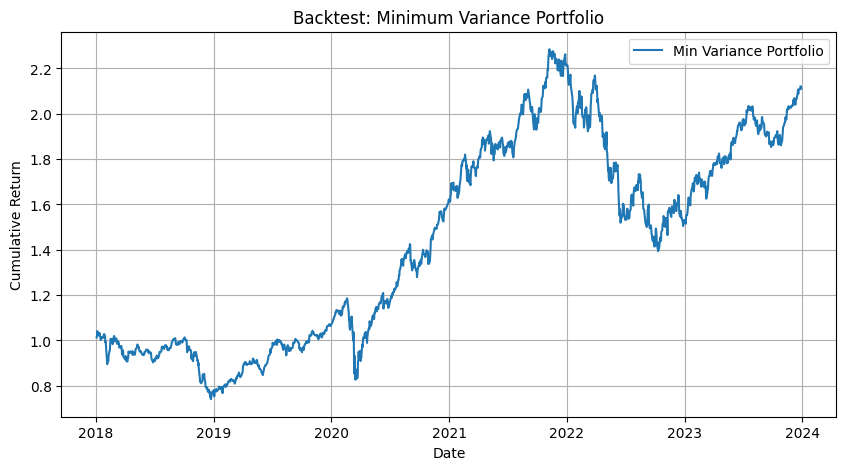

In [3]:
# Use full covariance matrix
cov = returns_df.cov()
weights = get_min_var_weights(cov)

# Compute daily portfolio return
portfolio_returns = (returns_df * weights).sum(axis=1)
cumulative_a = (1 + portfolio_returns).cumprod()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(cumulative_a, label="Min Variance Portfolio")
plt.title("Backtest: Minimum Variance Portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid()
plt.legend()
plt.show()

In [4]:
from scipy.optimize import minimize

# --- Configuration ---
tickers = ["AAPL", "NVDA", "VOO", "JPM", "GLD", "BTC-USD", "PFE"]
preds_path = "data/predictions/combined_predictions.csv"
returns_dir = "data/processed"

# --- Load predictions ---
pred_df = pd.read_csv(preds_path, index_col="Date", parse_dates=True)
print("Predictions loaded:", pred_df.shape)

# --- Load log returns ---
log_returns = {}
for ticker in tickers:
    path = f"{returns_dir}/{ticker}_log_returns.csv"
    df = pd.read_csv(path, index_col="Date", parse_dates=True)
    log_returns[ticker] = df["Log Return"]
    
# Combine into single DataFrame
returns_df = pd.concat(log_returns.values(), axis=1)
returns_df.columns = tickers
returns_df = returns_df.dropna()
print("Log returns shape:", returns_df.shape)

Predictions loaded: (1495, 7)
Log returns shape: (1508, 7)


In [5]:
# --- Daily returns using only predicted-up assets with min variance ---

def get_min_var_weights(cov_matrix):
    n_assets = len(cov_matrix)
    init_guess = np.repeat(1 / n_assets, n_assets)
    bounds = [(0.0, 1.0)] * n_assets
    constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    
    def portfolio_variance(w):
        return w @ cov_matrix @ w
    
    result = minimize(portfolio_variance, init_guess, bounds=bounds, constraints=constraints)
    return result.x

# Store daily returns
daily_returns = []

# Loop over all prediction dates
for date in pred_df.index:
    try:
        today_preds = pred_df.loc[date]
        up_assets = today_preds[today_preds == 1].index.tolist()

        if len(up_assets) == 0:
            # No assets predicted up → portfolio return is 0
            daily_returns.append(0.0)
            continue

        # Get today's returns for selected assets (1-day ahead)
        ret_row = returns_df.loc[date:date].copy()
        if ret_row.empty:
            daily_returns.append(0.0)
            continue

        ret_row = ret_row[up_assets]

        # Slice past N days for covariance (e.g., last 20 days)
        past_returns = returns_df[up_assets].loc[:date].tail(20)

        if past_returns.shape[0] < 5:
            daily_returns.append(0.0)
            continue

        cov = past_returns.cov().values
        weights = get_min_var_weights(cov)

        # Compute weighted return
        portfolio_ret = np.dot(weights, ret_row.values[0])
        daily_returns.append(portfolio_ret)

    except Exception as e:
        print(f"Error on {date}: {e}")
        daily_returns.append(0.0)

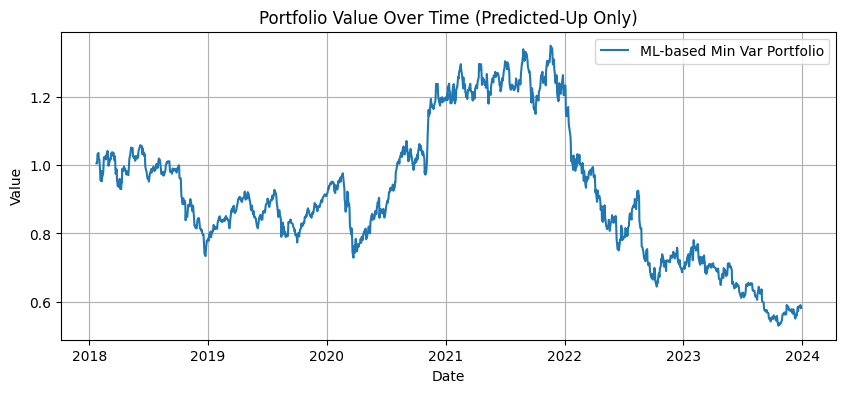

In [6]:
# --- Build portfolio value curve ---
daily_returns = pd.Series(daily_returns, index=pred_df.index)
cumulative_b = (1 + daily_returns).cumprod()

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.plot(cumulative_b, label="ML-based Min Var Portfolio")
plt.title("Portfolio Value Over Time (Predicted-Up Only)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()

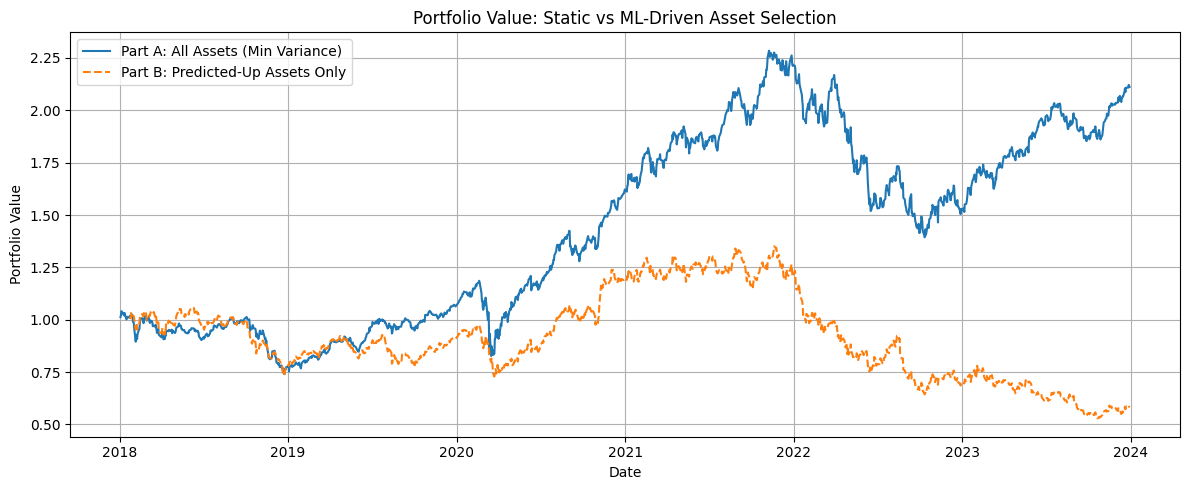

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(cumulative_a, label="Part A: All Assets (Min Variance)")
plt.plot(cumulative_b, label="Part B: Predicted-Up Assets Only", linestyle="--")
plt.title("Portfolio Value: Static vs ML-Driven Asset Selection")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()